### 합성곱층의 필요성
- 기존의 딥러닝 역전파는 순전파 과정에 따라 계산된 오차 정보가 신경망의 모든 노드로 전송
  (출력층 -> 은닉층 -> 입력층)
- 이러한 계산 과정은 복잡하고 많은 자원을 요구하며, 계산하는데도 많은 시간 소요
- 합성곱 신경망은 이미지 전체를 한 번에 계산하는 것이 아닌 이미지의 국소적 부분을 계산함으로써 시간과 자원을 절약, 이미지의 세밀한 부분까지 분석할 수 있음

### 합성곱층의 장점
- 이미지나 영상을 처리하는데 유용
이미지 분석은 3x3 배열을 오른쪽과 같이 펼쳐서 각 픽셀에 가중치를 곱하여 은닉층으로 전달
- 이미지를 펼쳐서 분석하면 데이터의 공간적 구조를 무시하게 되는데, 이것을 방지하기 위해 합성곱층 활용

### 합성곱 신경망 구조
- 음성 인식이나 이미지/영상 인식에서 주로 사용되는 신경망
- 컬러 이미지 같은 다차원 배열 처리에 특화되어 있으며, 계층 다섯개로 구성
  (입력층, 합성곱층, 풀링층, 완전연결층, 출력층)

### 풀링층
- 풀링층은 합성곱층과 유사하게 특성 맵의 차원을 다운 샘플링하여 연산량을 감소시키고, 주요한 특성 벡터를 추출하여 학습을 효과적으로 할 수 있게 함
- 풀링 연산에는 두가지가 사용
  - 최대 풀링(max pooling): 대상 영역에서 최댓값을 추출
  - 평균 풀링(average pooling): 대상 영역에서 평균을 반환
- 대부분의 합성곱 신경망에서는 최대 풀링을 사용, 평균풀링은 각 커널 값을 평균화시켜 주요한 가중치를 갖는 값의 특성이 없어질 수 있기 때문

### 완전연결층
- 합성곱층과 풀링층을 거치면서 차원이 축소된 특성 맵은 최종적으로 완전연결층으로 전달
- 이 과정에서 이미지는 3차원 벡터에서 1차원 벡터로 펼쳐짐 (flatten)
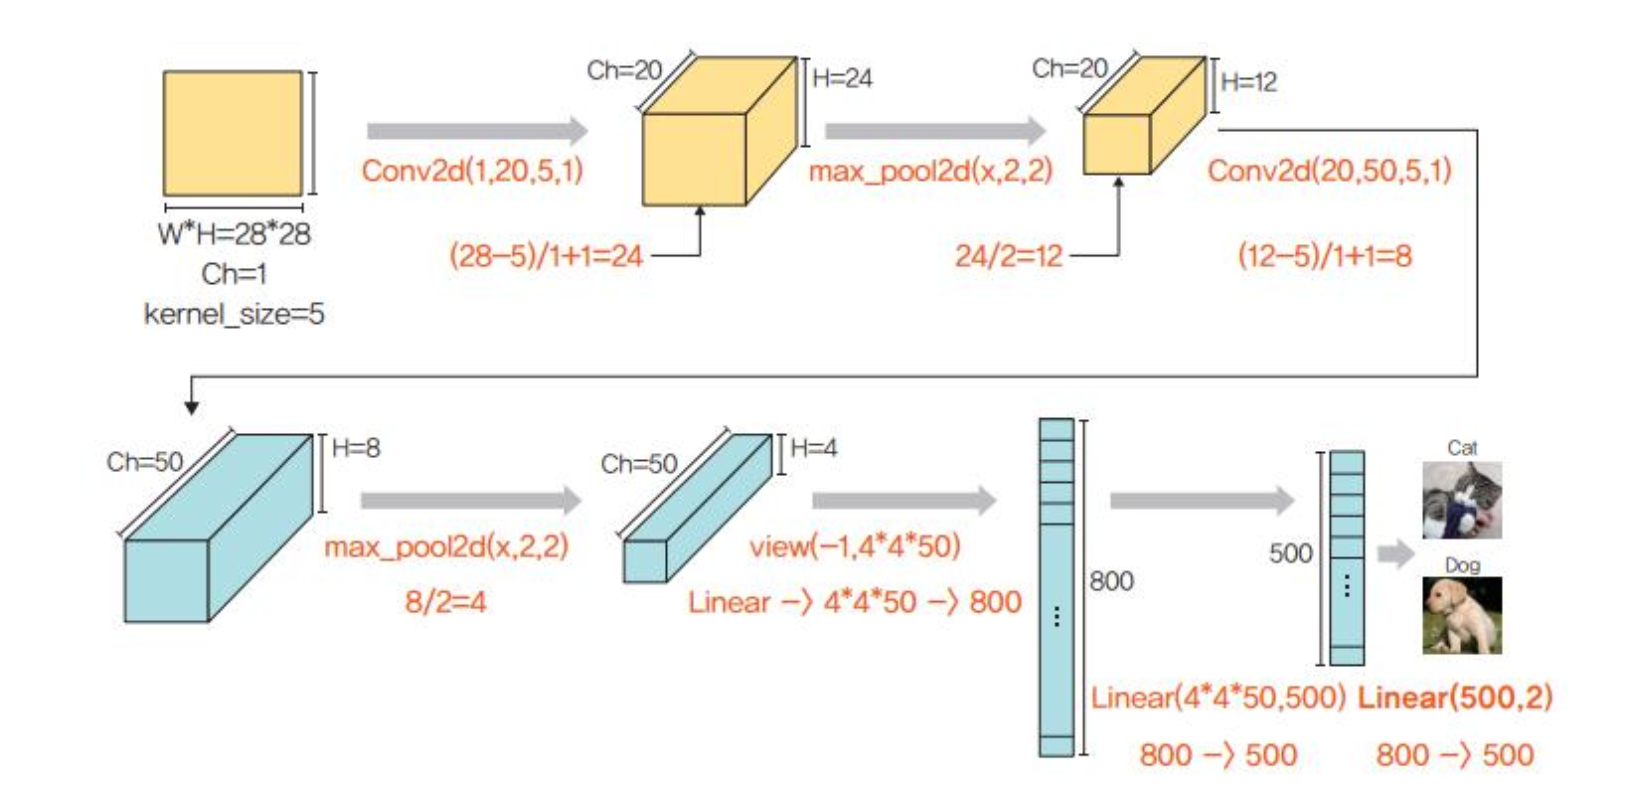

In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
import torchvision.datasets as datasets

trans = transforms.Compose([transforms.ToTensor()])

data_root = './data'
train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = trans)

test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = trans)

print(f"Train 데이터 개수: {len(train_set)}") # Train 데이터 개수 확인
print(f"Test 데이터 개수: {len(test_set)}") # Test 데이터 개수 확인
classes = train_set.classes # classes로 결과값들도 확인
classes

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Train 데이터 개수: 50000
Test 데이터 개수: 10000


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
batch_size = 128 # 128개의 배치사이즈로 미니배치

train_loader = DataLoader (
    train_set, batch_size=batch_size,
    shuffle = True
)

test_loader = DataLoader (
    test_set, batch_size=batch_size,
    shuffle = False
)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


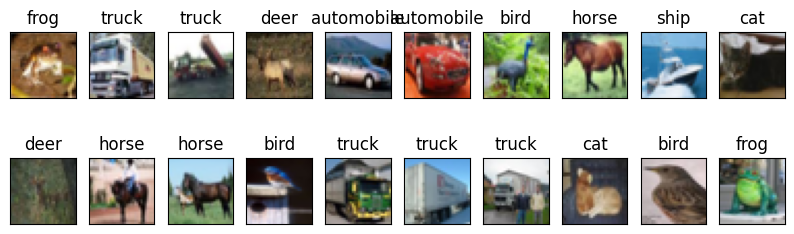

In [ ]:
plt.figure(figsize=(10,3))
for i in range(20):
  ax = plt.subplot(2, 10, i+1)

  # image, label 취득
  image, label = train_set[i]

  # 이미지 출력
  plt.imshow(np.transpose(image,(1,2,0)))
  ax.set_title(f'{classes[label]}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
class CNN1(nn.Module):
  def __init__(self):
    super(CNN1,self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # kernel = 필터 사이즈
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.l1 = nn.Linear(in_features=32*16*16, out_features=50)
    self.l2 = nn.Linear(in_features=50, out_features=10)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)

    x = x.view(x.size(0), -1)

    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    return x

```
입력: [3, 32, 32] (예시 이미지)
    │
Conv2d (필터 32개)
    │
ReLU 활성화
    │
MaxPooling (2x2) → [32, 16, 16]
    │
Flatten (벡터화) → [8192]
    │
Fully-connected (8192 → 50)
    │
ReLU 활성화
    │
Fully-connected (50 → 10)
    │
최종 출력 (클래스 10개)
```

In [ ]:
torch.cuda.manual_seed(123)

model = CNN1()
model.to(device)
lr = 1e-3

# 손실 함수: 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

history = np.zeros((0, 5))

num_epochs = 50
# tqdm 라이브러리 임포트
from tqdm.notebook import tqdm

num_epochs = 20

for epochs in range(num_epochs):
  train_acc, train_loss = 0, 0
  test_acc, test_loss = 0, 0
  n_train, n_test = 0, 0

  # 훈련 페이즈
  for inputs, labels in tqdm(train_loader):
    n_train += len(labels)

    # GPU 설정
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # Gradient 초기화

    outputs = model(inputs) # 순전파 계산

    loss = criterion(outputs, labels) # 손실값 계산

    loss.backward() # 역전파 계산

    optimizer.step() # 변수 업데이트

    predicted = outputs.max(axis=1)[1] # 실제 예측은 output중에서 가장 높은 값이 있는 위치

    train_loss += loss.item()
    train_acc += (predicted == labels).sum().item() # 예측과 실제값이 같은 것의 개수

  # 예측 페이즈
  for inputs_test, labels_test in test_loader:
    n_test += len(labels_test)

    # GPU 설정
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    outputs_test = model(inputs_test) # 순전파 계산

    loss_test = criterion(outputs_test, labels_test) # 손실값 계산

    predicted_test = outputs_test.max(axis=1)[1]

    test_loss += loss_test.item()
    test_acc += (predicted_test == labels_test).sum().item() # 손실 및 정확도 저장

  # 평가 결과 산출, 기록
  train_acc = train_acc / n_train # Train 정확도
  train_loss = train_loss / n_train # Train loss
  test_acc = test_acc / n_test # Test 정확도
  test_loss = test_loss / n_test # Test loss

  item = np.array([epochs + 1, train_loss, train_acc, test_loss, test_acc])
  history = np.vstack((history, item)) # Epoch 마다 손실 정확도 저장

  # Epoch 마다 손실과 정확도 표기
  print(f'Epoch [{epochs+1}/{num_epochs}, loss: {train_loss:.5f} acc: {train_acc:.2f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.2f}]')

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/20, loss: 0.01351 acc: 0.38 test_loss: 0.01167, test_acc: 0.47]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/20, loss: 0.01089 acc: 0.50 test_loss: 0.01049, test_acc: 0.53]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/20, loss: 0.00991 acc: 0.55 test_loss: 0.00989, test_acc: 0.55]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/20, loss: 0.00928 acc: 0.58 test_loss: 0.00937, test_acc: 0.58]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/20, loss: 0.00880 acc: 0.61 test_loss: 0.00911, test_acc: 0.59]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/20, loss: 0.00837 acc: 0.63 test_loss: 0.00885, test_acc: 0.61]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/20, loss: 0.00810 acc: 0.64 test_loss: 0.00868, test_acc: 0.62]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/20, loss: 0.00780 acc: 0.65 test_loss: 0.00895, test_acc: 0.61]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/20, loss: 0.00756 acc: 0.66 test_loss: 0.00850, test_acc: 0.62]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/20, loss: 0.00739 acc: 0.67 test_loss: 0.00844, test_acc: 0.63]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/20, loss: 0.00724 acc: 0.68 test_loss: 0.00836, test_acc: 0.63]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/20, loss: 0.00703 acc: 0.69 test_loss: 0.00841, test_acc: 0.63]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/20, loss: 0.00687 acc: 0.70 test_loss: 0.00833, test_acc: 0.64]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/20, loss: 0.00673 acc: 0.70 test_loss: 0.00854, test_acc: 0.63]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/20, loss: 0.00658 acc: 0.71 test_loss: 0.00850, test_acc: 0.63]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/20, loss: 0.00643 acc: 0.72 test_loss: 0.00824, test_acc: 0.64]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/20, loss: 0.00635 acc: 0.72 test_loss: 0.00814, test_acc: 0.64]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/20, loss: 0.00623 acc: 0.73 test_loss: 0.00817, test_acc: 0.65]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/20, loss: 0.00609 acc: 0.73 test_loss: 0.00833, test_acc: 0.64]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/20, loss: 0.00597 acc: 0.74 test_loss: 0.00840, test_acc: 0.64]


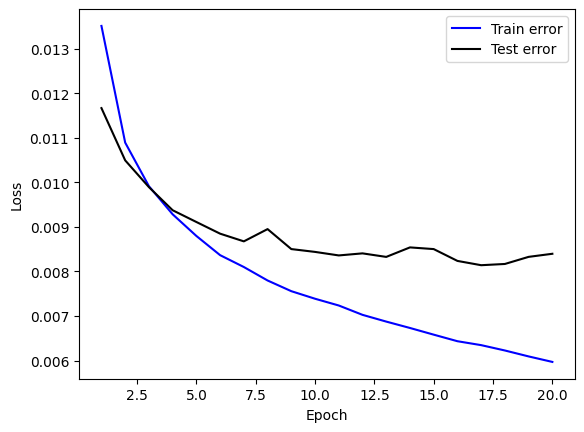

In [ ]:
# 학습 곡선 출력(손실)

plt.plot(history[:, 0], history[:, 1], 'b', label='Train error')
plt.plot(history[:, 0], history[:, 3], 'k', label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# 학습 곡선 출력 (정확도)

plt.plot(history[:, 0], history[:, 2], 'b', label='Train accuracy')
plt.plot(history[:, 0], history[:, 4], 'k', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

***
3/25<br>
## 합성곱 신경망 튜닝



### 과적합에 대한 대책(Dropout)
- 과적합을 해결하는 방법으로 드롭아웃이 있음
- 신경망 모델이 과적합되는 것을 피하기 위한 방법으로, 학습 과정 중 임의로 일부 노드들을 학습에서 제외시킴
```python
nn.Dropout(드롭비율)
```

### 배치 정규화
- BatchNorm2d: 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것
- 배치 단위나 계층에 따라 입력값의 분포가 모두 다르지만 정규화를 통해 분포를 가우시안 형태로 만듦
- 평균은 0, 표준편차는 1로 데이터의 분포가 조정
```python
nn.BatchNorm2d(채널수)
```

In [4]:
class CNN2(nn.Module): # 신경망의 다층화 튜닝
  def __init__(self):
    super(CNN2, self).__init__()

    # 배치 정규화
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)
    self.bn5 = nn.BatchNorm2d(128)
    self.bn6 = nn.BatchNorm2d(128)

    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        self.bn1, # 배치 정규화
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        self.bn2,
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2), # 드롭아웃
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        self.bn3,
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        self.bn4,
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.3),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        self.bn5,
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        self.bn6,
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.4)
        )
    self.l1 = nn.Linear(in_features=128*4*4, out_features=128)
    self.l2 = nn.Linear(in_features=128, out_features=10)

    self.relu = nn.ReLU()

    self.dropout1 = nn.Dropout(0.4) # 드롭아웃 지정

  def forward(self, x):
    x = self.layer1(x)

    x = x.view(x.size(0), -1)

    x = self.l1(x)
    x = self.relu(x)
    x = self.dropout1(x)
    x = self.l2(x)
    return x

In [10]:
torch.cuda.manual_seed(123)

model = CNN2()
model.to(device)
lr = 1e-3

# 손실 함수: 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

history = np.zeros((0, 5))

num_epochs = 50
# tqdm 라이브러리 임포트
from tqdm.notebook import tqdm

num_epochs = 20

for epochs in range(num_epochs):
  train_acc, train_loss = 0, 0
  test_acc, test_loss = 0, 0
  n_train, n_test = 0, 0

  # 훈련 페이즈
  for inputs, labels in tqdm(train_loader):
    n_train += len(labels)

    # GPU 설정
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # Gradient 초기화

    outputs = model(inputs) # 순전파 계산

    loss = criterion(outputs, labels) # 손실값 계산

    loss.backward() # 역전파 계산

    optimizer.step() # 변수 업데이트

    predicted = outputs.max(axis=1)[1] # 실제 예측은 output중에서 가장 높은 값이 있는 위치

    train_loss += loss.item()
    train_acc += (predicted == labels).sum().item() # 예측과 실제값이 같은 것의 개수

  # 예측 페이즈
  for inputs_test, labels_test in test_loader:
    n_test += len(labels_test)

    # GPU 설정
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    outputs_test = model(inputs_test) # 순전파 계산

    loss_test = criterion(outputs_test, labels_test) # 손실값 계산

    predicted_test = outputs_test.max(axis=1)[1]

    test_loss += loss_test.item()
    test_acc += (predicted_test == labels_test).sum().item() # 손실 및 정확도 저장

  # 평가 결과 산출, 기록
  train_acc = train_acc / n_train # Train 정확도
  train_loss = train_loss / n_train # Train loss
  test_acc = test_acc / n_test # Test 정확도
  test_loss = test_loss / n_test # Test loss

  item = np.array([epochs + 1, train_loss, train_acc, test_loss, test_acc])
  history = np.vstack((history, item)) # Epoch 마다 손실 정확도 저장

  # Epoch 마다 손실과 정확도 표기
  print(f'Epoch [{epochs+1}/{num_epochs}, loss: {train_loss:.5f} acc: {train_acc:.2f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.2f}]')

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/20, loss: 0.01181 acc: 0.45 test_loss: 0.00975, test_acc: 0.55]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/20, loss: 0.00879 acc: 0.60 test_loss: 0.00861, test_acc: 0.62]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/20, loss: 0.00772 acc: 0.65 test_loss: 0.00753, test_acc: 0.68]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/20, loss: 0.00697 acc: 0.69 test_loss: 0.00714, test_acc: 0.69]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/20, loss: 0.00649 acc: 0.71 test_loss: 0.00671, test_acc: 0.71]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/20, loss: 0.00608 acc: 0.73 test_loss: 0.00649, test_acc: 0.72]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/20, loss: 0.00579 acc: 0.75 test_loss: 0.00611, test_acc: 0.74]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/20, loss: 0.00542 acc: 0.76 test_loss: 0.00606, test_acc: 0.75]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/20, loss: 0.00519 acc: 0.77 test_loss: 0.00573, test_acc: 0.76]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/20, loss: 0.00500 acc: 0.78 test_loss: 0.00564, test_acc: 0.76]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/20, loss: 0.00480 acc: 0.79 test_loss: 0.00557, test_acc: 0.77]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/20, loss: 0.00464 acc: 0.80 test_loss: 0.00543, test_acc: 0.78]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/20, loss: 0.00439 acc: 0.81 test_loss: 0.00549, test_acc: 0.78]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/20, loss: 0.00429 acc: 0.82 test_loss: 0.00527, test_acc: 0.78]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/20, loss: 0.00413 acc: 0.82 test_loss: 0.00514, test_acc: 0.79]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/20, loss: 0.00398 acc: 0.83 test_loss: 0.00516, test_acc: 0.80]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/20, loss: 0.00386 acc: 0.83 test_loss: 0.00493, test_acc: 0.80]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/20, loss: 0.00378 acc: 0.84 test_loss: 0.00491, test_acc: 0.80]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/20, loss: 0.00362 acc: 0.84 test_loss: 0.00518, test_acc: 0.79]


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/20, loss: 0.00353 acc: 0.85 test_loss: 0.00496, test_acc: 0.81]


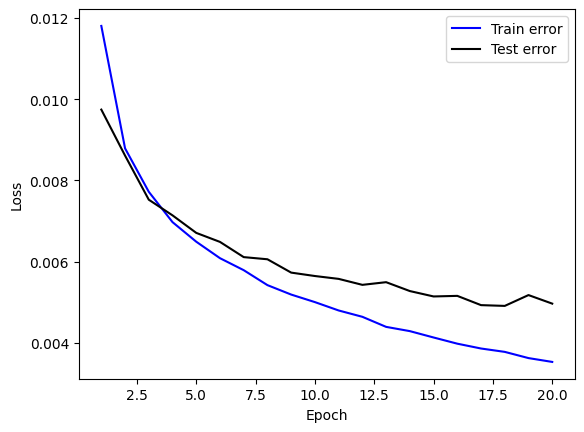

In [11]:
# 학습 곡선 출력(손실)

plt.plot(history[:, 0], history[:, 1], 'b', label='Train error')
plt.plot(history[:, 0], history[:, 3], 'k', label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

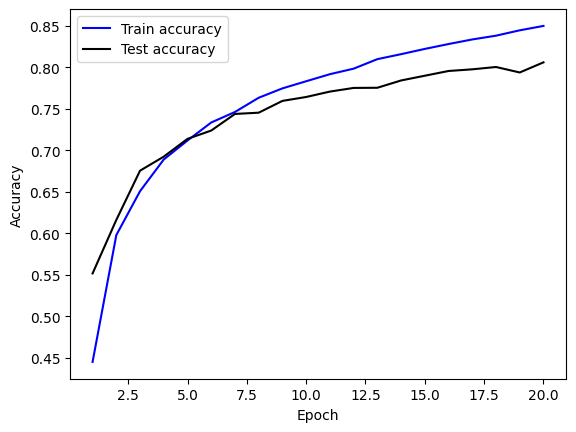

In [12]:
# 학습 곡선 출력 (정확도)

plt.plot(history[:, 0], history[:, 2], 'b', label='Train accuracy')
plt.plot(history[:, 0], history[:, 4], 'k', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 데이터 증강
이미지 뒤집기
```python
transforms.RandomHorizontalFlip() # 좌우대칭
transforms.RandomVerticalFlip() # 상하대칭
```

이미지 삭제
```python
transforms.RandomErasing()
```

이미지 잘라내기 and Resize
```python
transforms.RandomResizedCrop()
```

이미지 밝기, 대비, 채도, 색조 변경
```python
transforms.ColorJitter()
```

데이터 정규화
```python
transforms.Normalize() # 각 채널별 평균(means)을 뺀 뒤 표준편차(std)로 나누어 정규화를 진행
transforms.Normalize(0.5, 0.5) # 기본
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet 학습한 수백만장 이미지 평균
transforms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차))
```

변환 후 결과 = (픽셀 값 - 각 채널 평균) / (각 채널 표준편차)

최종적으로 사용하고 싶은 증강을 조합하여 학습 데이터 세팅

In [13]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(0.5, 0.5),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomErasing(p=0.5, scale = (0.02, 0.33), ratio = (0.33, 3.3))
                            ])

data_root = './data'
train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = trans)

train_loader = DataLoader (
    train_set, batch_size=batch_size,
    shuffle = True
)